In [1]:
import fastai
fastai.__version__

'2.1.4'

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from sklearn.metrics import mean_squared_error as sk_mse

from fastai.learner import Learner
from fastai.metrics import rmse
from fastai.tabular.model import get_emb_sz
from fastai.tabular.all import *
from fastai.learner import *
from dies.data import *
# tp_from_df, get_y_ranges, split_by_year, create_consistent_number_of_sampler_per_day, TimeseriesTransform
from dies.utils_pytorch import dev_to_np, xavier_init_uniform, np_to_dev
from dies.utils import set_random_states
from dies.autoencoder import ConvolutionalAutoEncoder
from dies.losses import CnnMSELoss
from dies.cnn import CNN
from dies.embedding import Embedding

%load_ext autoreload
%autoreload 2
sns.set_context('poster')
sns.set_style('whitegrid')
mpl.rcParams["legend.loc"] = 'upper right'

/home/scribbler/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
set_random_states(23)

In [4]:
with pd.HDFStore('./data/GEFCOM_Z1.h5') as store:
    df = store['powerdata']

In [5]:
df = df.fillna(df.mean())
df = df.dropna(axis=1)

In [6]:
df.TimeUTC = pd.to_datetime(df.TimeUTC, infer_datetime_format=True, utc=True)
df.set_index('TimeUTC', inplace=True)
df.PowerGeneration = df.PowerGeneration.apply(float) / df.MaxPowerGeneration.apply(float)
df.drop('MaxPowerGeneration', axis=1, inplace=True)

In [7]:
df.head()

,PowerGeneration,WindDirectionMeridional100m,WindDirectionMeridional10m,WindDirectionZonal100m,WindDirectionZonal10m,WindSpeed100m,WindSpeed10m
TimeUTC,,,,,,,
2012-01-01 01:00:00+00:00,0.000000,-3.666076,-2.681966,2.864280,2.124600,4.652334,3.421530
2012-01-01 02:00:00+00:00,0.054879,-2.464761,-1.796960,3.344859,2.521695,4.154892,3.096451
2012-01-01 03:00:00+00:00,0.110234,-1.214093,-0.822516,3.508448,2.672210,3.712577,2.795932
2012-01-01 04:00:00+00:00,0.165116,-0.355546,-0.143642,3.215233,2.457504,3.234831,2.461699
2012-01-01 05:00:00+00:00,0.156940,0.332701,0.389576,2.957678,2.245898,2.976332,2.279435


In [8]:
df['DayOfYear'] = df.index.dayofyear
df['Hour'] = df.index.hour

In [9]:
df.shape

(17544, 9)

In [10]:
df = create_consistent_number_of_sampler_per_day(df, 24)
df.shape

(17520, 9)

In [11]:
cols = [ 'WindDirectionMeridional100m',
       'WindDirectionMeridional10m', 'WindDirectionZonal100m',
       'WindDirectionZonal10m', 'WindSpeed100m', 'WindSpeed10m']

cat_cols = ['DayOfYear']

tp = tp_from_df(df, y_columns=['PowerGeneration'], x_columns=cols, 
                cat_columns = cat_cols, 
                standardize_X=True,
                do_split_by_n_weeks=True)#, timeseries_length=24, batch_first=True,sequence_last=True)

/home/scribbler/anaconda3/lib/python3.8/site-packages/fastai/tabular/core.py:147: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


In [12]:
train_tl = TimeseriesTransform(tp, 
                        timeseries_length = 24,
                        batch_first=True, 
                        sequence_last=True, 
                        is_train=True, 
                        )#check_consistent_number_per_days=True)

valid_tl = TimeseriesTransform(tp, 
                        timeseries_length = 24,
                        batch_first=True, 
                        sequence_last=True, 
                        is_train=False, 
                        is_valid=True,
                        )#check_consistent_number_per_days=True)

/home/scribbler/workspace/dies/dies/data.py:562: UserWarning: Dropped 507 elements due to inconsistent categoricals in a sequence.
  warnings.warn(
/home/scribbler/workspace/dies/dies/data.py:562: UserWarning: Dropped 98 elements due to inconsistent categoricals in a sequence.
  warnings.warn(


In [13]:
train_tl.tp.items.shape[0] / 24, valid_tl.tp.items.shape[0] / 24

(556.0, 173.0)

In [14]:
dls = DataLoaders.from_dsets(train_tl.to_tfmd_lists(), valid_tl.to_tfmd_lists(), bs = 5)
test_batch = dls.one_batch()

In [15]:
train_tl.xs

tensor([[[-1.4356, -1.6007, -1.5009,  ...,  0.4137,  0.0110,  0.0956],
         [-1.7253, -1.9398, -1.8308,  ...,  0.1733, -0.0926,  0.0860],
         [ 0.1942,  0.6498,  0.9496,  ..., -1.2422, -0.9715, -0.7772],
         [ 0.2391,  0.7629,  1.1180,  ..., -1.0845, -0.9139, -0.8513],
         [ 0.7099,  1.2851,  1.3655,  ..., -0.8237, -1.3694, -1.7070],
         [ 1.0945,  1.7168,  1.8193,  ..., -0.9823, -1.2005, -1.3432]],

        [[ 0.2015, -0.4026, -0.3511,  ...,  1.6344,  1.6749,  1.6454],
         [ 0.2310, -0.5669, -0.5099,  ...,  1.8807,  1.9791,  1.9824],
         [-0.6124, -0.8977, -0.1683,  ...,  0.2558,  0.0945,  0.0268],
         [-0.6656, -1.0729, -0.1580,  ...,  0.3486,  0.1810,  0.1093],
         [-1.9435, -1.0727, -1.4897,  ...,  0.7097,  0.7134,  0.6333],
         [-1.5566, -0.5520, -1.0643,  ...,  1.1377,  1.2298,  1.2118]],

        [[ 1.5529,  1.6144,  1.6347,  ...,  0.5919,  0.6784,  0.7537],
         [ 1.8942,  1.9873,  2.0214,  ...,  0.6775,  0.8288,  0.9353],
  

In [16]:
dls.train.xs.shape

torch.Size([49, 6, 24])

In [17]:
test_batch

(tensor([[[ 23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,
            23,  23,  23,  23,  23,  23,  23,  23,  23,  23]],
 
         [[276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276,
           276, 276, 276, 276, 276, 276, 276, 276, 276, 276]],
 
         [[270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270,
           270, 270, 270, 270, 270, 270, 270, 270, 270, 270]],
 
         [[279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279,
           279, 279, 279, 279, 279, 279, 279, 279, 279, 279]],
 
         [[288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
           288, 288, 288, 288, 288, 288, 288, 288, 288, 288]]]),
 tensor([[[-1.8853e-01, -1.6835e-01,  5.6472e-02,  2.1694e-01,  3.4564e-01,
            3.8616e-01,  4.6485e-01,  7.7954e-01,  1.4877e+00,  1.6619e+00,
            1.3933e+00,  1.1929e+00,  1.0607e+00,  9.5603e-01,  8.2946e-01,
            6.9125e-01,  6.4022e-01,  7.17

In [18]:
test_batch[0].shape, test_batch[1].shape, test_batch[2].shape

(torch.Size([5, 1, 24]), torch.Size([5, 6, 24]), torch.Size([5, 1, 24]))

In [19]:
from dies.embedding import Embedding
from dies.cnn import CNN

input_size = tp.conts.shape[1]
embedding_dimensions = [(367, 12)]

fc = 4

cnn_structure = [input_size, 
                 input_size*fc, 
                 input_size*fc,  
                 input_size*fc, 
                 input_size*fc,  
                 1]

ann_model = CNN(cnn_structure=cnn_structure, 
                kernel_size=3, 
                #embedding_dimensions=embedding_dimensions,
                stride=1, 
                dilation=1)

In [20]:
ann_model.unfreeze()

In [21]:
test_batch = dls.one_batch()
pred = ann_model(categorical_data=test_batch[0], continuous_data=test_batch[1])
pred.shape

torch.Size([5, 1, 24])

In [22]:
learn = Learner(
    dls,
    ann_model,
    loss_func=CnnMSELoss(),
    metrics=rmse
)

In [23]:
learn.model._cnn

Sequential(
  (cnn_layer_0_6_24): ConvLayer(
    (0): Conv1d(6, 24, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): ReLU()
  )
  (cnn_layer_1_24_24): ConvLayer(
    (0): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): ReLU()
  )
  (cnn_layer_2_24_24): ConvLayer(
    (0): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): ReLU()
  )
  (cnn_layer_3_24_24): ConvLayer(
    (0): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): ReLU()
  )
  (cnn_layer_4_24_1): ConvLayer(
    (0): Conv1d(24, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  )
)

In [24]:
learn.summary()

CNN (Input shape: ['5 x 1 x 24', '5 x 6 x 24'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          5 x 6 x 24           12         True      
________________________________________________________________
Conv1d               5 x 24 x 24          456        True      
________________________________________________________________
ReLU                 5 x 24 x 24          0          False     
________________________________________________________________
Conv1d               5 x 24 x 24          1,752      True      
________________________________________________________________
ReLU                 5 x 24 x 24          0          False     
________________________________________________________________
Conv1d               5 x 24 x 24          1,752      True      
________________________________________________________________
ReLU                 5 x 24 x 24          0          False     
__________________________________________________

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=9.12010818865383e-07)

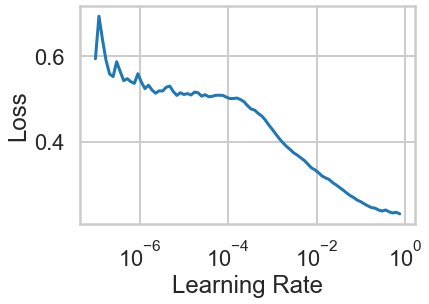

In [25]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(20, lr_max=1e-2, wd=0.0)

epoch,train_loss,valid_loss,_rmse,time
0,0.267143,0.085737,0.292809,00:00
1,0.178746,0.069092,0.262853,00:00
2,0.133715,0.081590,0.285639,00:00
3,0.110371,0.059915,0.244775,00:00
4,0.096052,0.064750,0.254461,00:00
5,0.086136,0.051162,0.226190,00:00
6,0.077417,0.077854,0.279023,00:00
7,0.071333,0.064932,0.254818,00:00
8,0.066900,0.052313,0.228721,00:00
9,0.062209,0.055284,0.235126,00:00


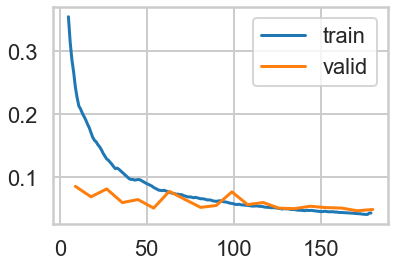

In [27]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=7.585775847473997e-07)

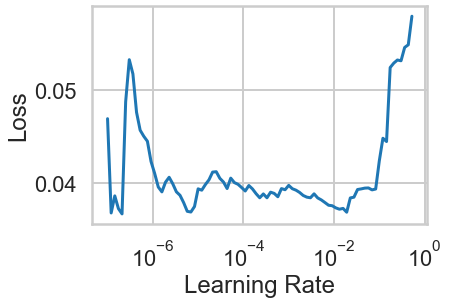

In [28]:
learn.lr_find()

In [29]:
learn.fit(30, lr=1e-3)

epoch,train_loss,valid_loss,_rmse,time
0,0.038844,0.048952,0.221250,00:00
1,0.040646,0.049606,0.222725,00:00
2,0.041811,0.054469,0.233385,00:00
3,0.040038,0.056082,0.236817,00:00
4,0.039323,0.047990,0.219066,00:00
5,0.040478,0.048041,0.219183,00:00
6,0.040262,0.051008,0.225849,00:00
7,0.040707,0.053956,0.232285,00:00
8,0.038898,0.049840,0.223248,00:00
9,0.037279,0.048057,0.219220,00:00


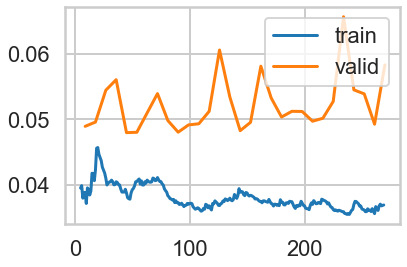

In [30]:
learn.recorder.plot_loss()

In [31]:
# ds_idx=1, refers to valid dataset, rmse should be between 0.16-0.18
preds, targets = learn.get_preds(ds_idx=1)
print(f'Valid nRMSE: {sk_mse(to_np(targets).ravel(), to_np(preds).ravel())**0.5}')

Valid nRMSE: 0.24155977638702905


In [32]:
from fastai.tabular.model import *

In [33]:
len(preds.view(-1))

1800

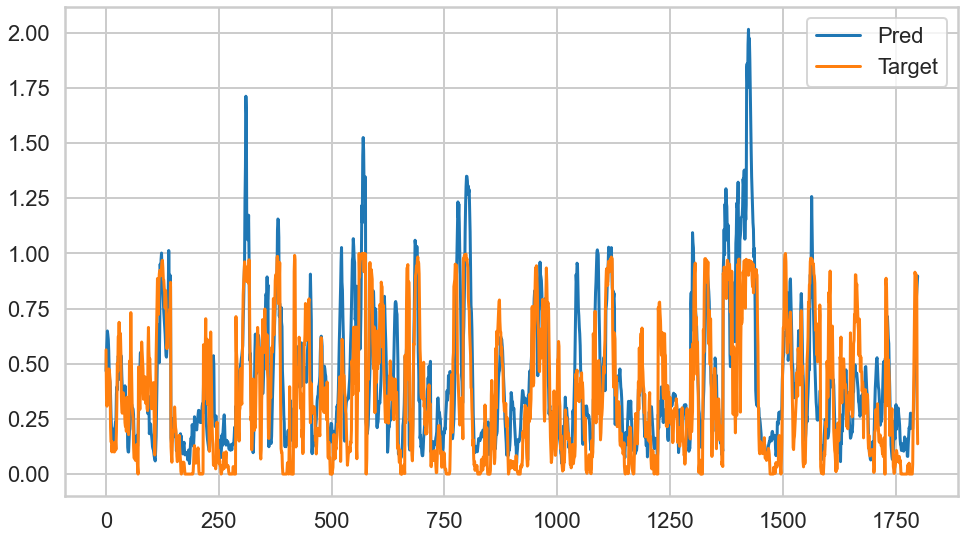

In [34]:
sid,eid = 0, 3000
plt.figure(figsize=(16,9))
plt.plot(preds.view(-1)[sid:eid], label="Pred")
plt.plot(targets.view(-1)[sid:eid], label="Target")
plt.legend()
plt.show()